# Chapter 9 - Temporal forcing and time-dependent parameters 

```{contents} Table of Contents
:depth: 3
```

Up until this point, we have assumed that the dynamical systems governing the spread of a pathogen rely on a finite set of fixed parameter values. 
For example, for the SIR model, we assume that $\beta$ the transmission rate and $1/\gamma$ the average infectious period do not change over time. 

\begin{align}
    \frac{dS}{dt} &= -\beta S \frac{I}{N}\\ 
    \frac{dI}{dt} &= \beta S \frac{I}{N} - \gamma I  \\ 
    \frac{dR}{dt} &= \gamma I
\end{align}

We see that the parameter values in the above model are constants (i.e. not functions of time). 

There are many different situations where time-dependent parameters are a more appropriate way to model an outbreak.

## Intervention for compartmental models
The simplest example is when we assume that transmission has changed because of an intervention.
This was explored in Chapter 4 for the Reed-Frost model. 
For completeness we will explore an intervention model below for compartmental models. 

Assume that we wish to model the number of susceptible, infectious, and removed individuals from time $0$ to time $T$ in increments of $1$. For example, we may assume that we observe these diseases states from week 0 to week 31 in increments of one week. 

Assume that an intervention will be implemented at time $T'$.
When the intervention is implemented then it will reduce the transmission rate by a proportion $\rho$ for $0 < \rho < 1$ for $\tau$ time units. 

The above assumptions change our SIR model from one with a constant set of parameters $\theta = (\beta, \gamma)$ to a model with parameter values that depend on time. These models are (often) called **Time-dependent models** or sometimes a model with time-varying parameters, etc. 

We modify the above SIR such that the constant $\beta$ is not a function of time unit, $t$, or $\beta(t)$.
Note: Time-dependent models include models with constant parameter values. 


Our intervention model above can be specified as 

\begin{align}
    \frac{dS}{dt} &= -\beta(t) S \frac{I}{N}\\ 
    \frac{dI}{dt} &= \beta(t) S \frac{I}{N} - \gamma I  \\ 
    \frac{dR}{dt} &= \gamma I\\ 
    %
    \beta(t)       &= %
       \begin{cases}
           \rho \beta &  T' \le t \le T' + \tau \\ 
           \beta & \text{otherwise}
       \end{cases}
\end{align}

There are just two changes to move our original model to an intervention model with a time-dependent intervention:
1. The constant $\beta$ in the dynamical system changes to a time-dependent function of time $\beta(t)$
2. We need to add an additional line that describes the behavior of $\beta(t)$ over time.

Lets look at the implementation of this model in the computer. 
We'll use scipy and numpy.  
First, lets remember how to solve the original SIR *without time-dependent parameters*. 

In [112]:
import numpy as np                     #--for array and matrix computations 
from scipy.integrate import solve_ivp  #--needed to solve the ODE system 
import matplotlib.pyplot as plt        #---for plotting 

In [113]:
def sir(t,y, beta, gamma,n):
    s,i,r = y                    #<- We assume that y holds the values s,i,r at each tiny time step from start to end
    ds_dt = -beta*s*(i/n)     
    di_dt =  beta*s*(i/n) - gamma*i
    dr_dt =  gamma*i
    return [ds_dt, di_dt, dr_dt] #<-- Its our job to compute the derivatives and return them as a list

In [114]:
start = 0    #--start at time 0
end   = 20   #--end   at time 20 

#--set the number of S,I,R at time 0. 
S0 = 100
I0 = 1
R0 = 0.

#--Compute the total number of individuls (n)
n  = S0+I0+R0 

initial_conditions = (S0,I0,R0) #<--Grouped initial conditions into a tuple

#--Set values for beta and gamma
beta  = 2.0
gamma = 0.75

In [115]:
solution = solve_ivp( fun     = sir
                     , t_span = (start,end)
                     , y0     = initial_conditions
                     , args   = (beta, gamma, n) )

#--Extract solutions from the object called "solution"
times = solution.t
St    = solution.y[0,:] #<-first row  is S
It    = solution.y[1,:] #<-second row is I
Rt    = solution.y[2,:] #<-third row  is R

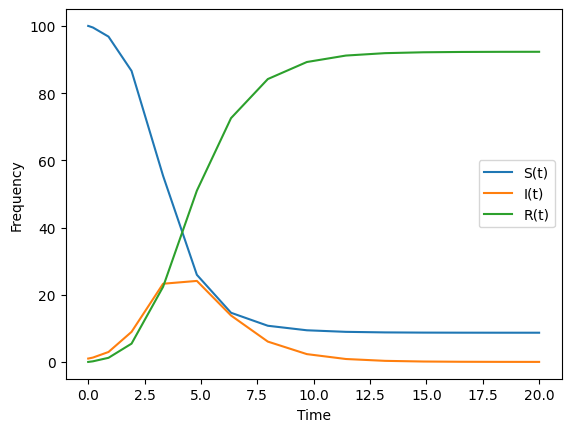

In [116]:
#--plot the results
plt.plot(times,St, label = "S(t)")
plt.plot(times,It, label = "I(t)")
plt.plot(times,Rt, label = "R(t)")

plt.xlabel("Time")
plt.ylabel("Frequency")
plt.legend()

plt.show()

To change our model to the above, time-dependent model, we need to modify the following piece of code

In [117]:
def sir(t,y, beta, gamma,n):
    s,i,r = y                    #<- We assume that y holds the values s,i,r at each tiny time step from start to end
    ds_dt = -beta*s*(i/n)     
    di_dt =  beta*s*(i/n) - gamma*i
    dr_dt =  gamma*i
    return [ds_dt, di_dt, dr_dt] #<-- Its our job to compute the derivatives and return them as a list

In the above, beta does not change as a function of $t$. 
To modify this, we will need to add a function that takes as input the value $t$ (and additionally the parameter $\rho$ as well as when the intervention begins and ends) and outputs the value of $\beta$ at time $t$. 

In [118]:
def specify_intervention_beta(t,beta, intervention_begin,intervention_end,rho):
    if t >=intervention_begin and t<=intervention_end:
        return rho*beta
    else:
        return beta

Lets specify the effectiveness of the intervention, $\rho$, and when the intervention is in effect. 

In [119]:
intervention_begin = 2.
intervention_end   = 4.
beta               = 2. 
effectiveness      = 1-0.40 # a 20% reduction in transmission

To include our time-dependent beta, we need to include in the above code a function that takes in $t$ and outputs $\beta$.
We also need our function to take as input the three parameters `intervention_begin`,`intervention_end`, and `effectiveness`. 
There are, typically two ways to do this. 

### Lambda functions
A lambda function is specified like this

In [120]:
beta_t = lambda t: specify_intervention_beta(t, 2., 2. ,4.,1-0.40)
# or---because we assigned the above variables to values---
beta_t = lambda t: specify_intervention_beta(t, beta, intervention_begin,intervention_end,effectiveness)

A lambda function is a method for creating a new inline function where you specify the inputs (after the keyword lambda) and body of the function is specified after a colon. 
Now ```beta_t``` is a function with input ```t```.

In [121]:
print(beta_t(1))
print(beta_t(2))
print(beta_t(5))

2.0
1.2
2.0


### Partial functions
A partial function is specified like this 

In [122]:
from functools import partial
beta_t = partial(specify_intervention_beta, beta = 2.,intervention_begin=2.,intervention_end=4.,rho=1-0.40  )

```Partial``` takes as input the function that you wish to prefill and values to prefill.
In our case, we want to prefill the inputs: beta, intervention_begin, intervention_end, and the input rho. 
We dont include a value for the input $t$ because we want our new function to take as input the variable $t$.
For partial, any inputs that are not pre-filled are considered to be inputs in our new function. 

print(beta_t(1))
print(beta_t(2))
print(beta_t(5))

To add in our time-dependent function, we include our pre-filled function in the dynamical system as 

In [123]:
def sir(t,y,gamma,n):
    s,i,r = y         #<- We assume that y holds the values s,i,r at each tiny time step from start to end

    beta = beta_t(t)  #<-- we see that our new beta is a function of t above. 
    
    ds_dt = -beta*s*(i/n)     
    di_dt =  beta*s*(i/n) - gamma*i
    dr_dt =  gamma*i
    return [ds_dt, di_dt, dr_dt] #<-- Its our job to compute the derivatives and return them as a list

The only change is that we assign beta to be a function that changes with changing values of $t$. 

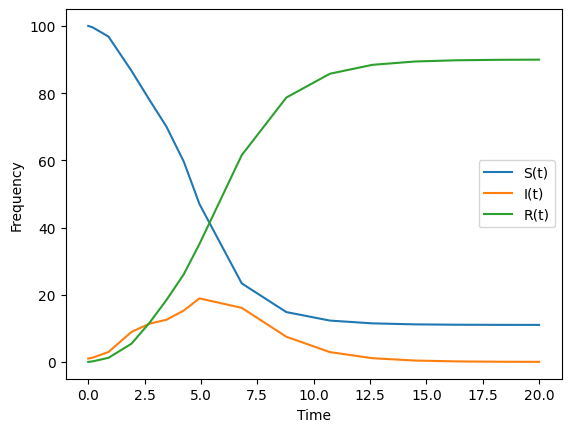

In [124]:
solution = solve_ivp( fun     = sir
                     , t_span = (start,end)
                     , y0     = initial_conditions
                     , args   = (gamma, n) )

#--Extract solutions from the object called "solution"
times = solution.t
St__intervene    = solution.y[0,:] #<-first row  is S
It__intervene    = solution.y[1,:] #<-second row is I
Rt__intervene    = solution.y[2,:] #<-third row  is R

#--plot the results
plt.plot(times,St__intervene, label = "S(t)")
plt.plot(times,It__intervene, label = "I(t)")
plt.plot(times,Rt__intervene, label = "R(t)")

plt.xlabel("Time")
plt.ylabel("Frequency")
plt.legend()

plt.show()

Lets compare the original, and intervened upon, number of infected individuals over time. 

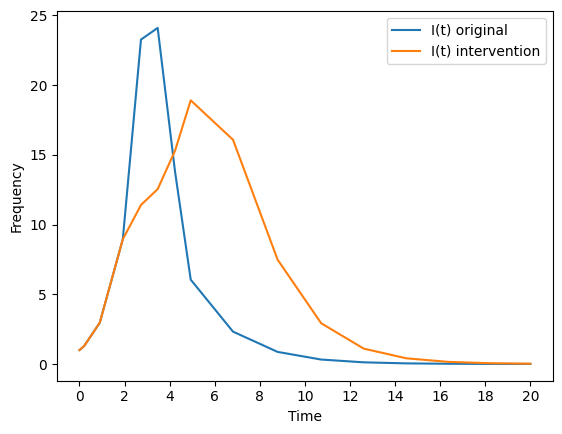

In [125]:
#--plot the results

plt.plot(times,It           , label = "I(t) original")
plt.plot(times,It__intervene, label = "I(t) intervention")

plt.xlabel("Time")
plt.ylabel("Frequency")

plt.xticks(np.arange(0,20+1,2))

plt.legend()